# Acceleration with Numba

We show how the computation of cost functions can be dramatically accelerated with numba's JIT compiler.

The run-time of iminuit is usually dominated by the execution time of the cost function. To get good performance, it recommended to use array arthimetic and scipy and numpy functions in the body of the cost function. Python loops should be avoided, but if they are unavoidable, [numba](https://numba.pydata.org/) can help. Numba can also parallelize numerical calculations to make full use of multi-core CPUs and even do computations on the GPU.

Note: This tutorial shows how one can generate faster pdfs with Numba. Before you start to write your own pdf, please check whether one is already implemented in the [numba_stats library](https://github.com/HDembinski/numba-stats). If you have a pdf that is not included there, please consider contributing it to numba_stats.

In [1]:
# !pip install matplotlib numpy numba scipy iminuit
from iminuit import Minuit
import numpy as np
import numba as nb
import math
from scipy.stats import expon, norm
from matplotlib import pyplot as plt
from argparse import Namespace

The standard fit in particle physics is the fit of a peak over some smooth background. We generate a Gaussian peak over exponential background, using scipy.

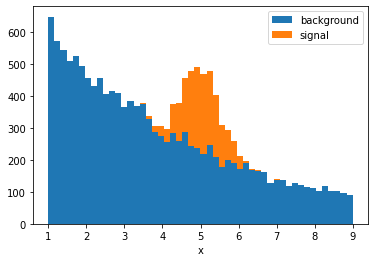

In [2]:
np.random.seed(1)  # fix seed

# true parameters for signal and background
truth = Namespace(n_sig=2000, f_bkg=10, sig=(5.0, 0.5), bkg=(0.0, 4.0))
n_bkg = truth.n_sig * truth.f_bkg

# make a data set
x = np.empty(truth.n_sig + n_bkg)

# fill m variables
x[: truth.n_sig] = norm(*truth.sig).rvs(truth.n_sig)
x[truth.n_sig :] = expon(*truth.bkg).rvs(n_bkg)

# cut a range in x
xrange = np.array((1.0, 9.0))
ma = (xrange[0] < x) & (x < xrange[1])
x = x[ma]

plt.hist(
    (x[truth.n_sig :], x[: truth.n_sig]),
    bins=50,
    stacked=True,
    label=("background", "signal"),
)
plt.xlabel("x")
plt.legend();

In [3]:
# ideal starting values for iminuit
start = np.array((truth.n_sig, n_bkg, truth.sig[0], truth.sig[1], truth.bkg[1]))


# iminuit instance factory, will be called a lot in the benchmarks blow
def m_init(fcn):
    m = Minuit(fcn, start, name=("ns", "nb", "mu", "sigma", "lambd"))
    m.limits = ((0, None), (0, None), None, (0, None), (0, None))
    m.errordef = Minuit.LIKELIHOOD
    return m

In [4]:
# extended likelihood (https://doi.org/10.1016/0168-9002(90)91334-8)
# this version uses numpy and scipy and array arithmetic
def nll(par):
    n_sig, n_bkg, mu, sigma, lambd = par
    s = norm(mu, sigma)
    b = expon(0, lambd)
    # normalisation factors are needed for pdfs, since x range is restricted
    sn = s.cdf(xrange)
    bn = b.cdf(xrange)
    sn = sn[1] - sn[0]
    bn = bn[1] - bn[0]
    return (n_sig + n_bkg) - np.sum(
        np.log(s.pdf(x) / sn * n_sig + b.pdf(x) / bn * n_bkg)
    )


nll(start)

-103168.78482586428

In [5]:
%%timeit -r 3 -n 1
m = m_init(nll)  # setup time is negligible
m.migrad();

259 ms ± 5.78 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Let's see whether we can beat that. The code above is already pretty fast, because numpy and scipy routines are fast, and we spend most of the time in those. But these implementations do not parallelize the execution and are not optimised for this particular CPU, unlike numba-jitted functions.

To use numba, in theory we just need to put the `njit` decorator on top of the function, but often that doesn't work out of the box. numba understands many numpy functions, but no scipy. We must evaluate the code that uses scipy in 'object mode', which is numba-speak for calling into the Python interpreter.

In [6]:
# first attempt to use numba
@nb.njit(parallel=True)
def nll(par):
    n_sig, n_bkg, mu, sigma, lambd = par
    with nb.objmode(spdf="float64[:]", bpdf="float64[:]", sn="float64", bn="float64"):
        s = norm(mu, sigma)
        b = expon(0, lambd)
        # normalisation factors are needed for pdfs, since x range is restricted
        sn = np.diff(s.cdf(xrange))[0]
        bn = np.diff(b.cdf(xrange))[0]
        spdf = s.pdf(x)
        bpdf = b.pdf(x)
    no = n_sig + n_bkg
    return no - np.sum(np.log(spdf / sn * n_sig + bpdf / bn * n_bkg))


nll(start)  # test and warm-up JIT

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


-103168.78482586429

In [7]:
%%timeit -r 3 -n 1 m = m_init(nll)
m.migrad()

298 ms ± 2.57 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


It is even a bit slower. :( Let's break the original function down by parts to see why.

In [8]:
# let's time the body of the function
n_sig, n_bkg, mu, sigma, lambd = start
s = norm(mu, sigma)
b = expon(0, lambd)
# normalisation factors are needed for pdfs, since x range is restricted
sn = np.diff(s.cdf(xrange))[0]
bn = np.diff(b.cdf(xrange))[0]
spdf = s.pdf(x)
bpdf = b.pdf(x)
no = n_sig + n_bkg
# no - np.sum(np.log(spdf / sn * n_sig + bpdf / bn * n_bkg))

%timeit -r 3 -n 100 norm(*start[2:4]).pdf(x)
%timeit -r 3 -n 500 expon(0, start[4]).pdf(x)
%timeit -r 3 -n 1000 np.sum(np.log(spdf / sn * n_sig + bpdf / bn * n_bkg))

1.03 ms ± 15.7 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
956 µs ± 17.2 µs per loop (mean ± std. dev. of 3 runs, 500 loops each)
118 µs ± 1.54 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)


Most of the time is spend in `norm` and `expon` which numba could not accelerate and the total time is dominated by the slowest part.

This, unfortunately, means we have to do much more manual work to make the function faster, since we have to replace the scipy routines with Python code that numba can accelerate and run in parallel.

In [9]:
kwd = {"parallel": True, "fastmath": True}


@nb.njit(**kwd)
def sum_log(fs, spdf, fb, bpdf):
    return np.sum(np.log(fs * spdf + fb * bpdf))


@nb.njit(**kwd)
def norm_pdf(x, mu, sigma):
    invs = 1.0 / sigma
    z = (x - mu) * invs
    invnorm = 1 / np.sqrt(2 * np.pi) * invs
    return np.exp(-0.5 * z ** 2) * invnorm


@nb.njit(**kwd)
def nb_erf(x):
    y = np.empty_like(x)
    for i in nb.prange(len(x)):
        y[i] = math.erf(x[i])
    return y


@nb.njit(**kwd)
def norm_cdf(x, mu, sigma):
    invs = 1.0 / (sigma * np.sqrt(2))
    z = (x - mu) * invs
    return 0.5 * (1 + nb_erf(z))


@nb.njit(**kwd)
def expon_pdf(x, lambd):
    inv_lambd = 1.0 / lambd
    return inv_lambd * np.exp(-inv_lambd * x)


@nb.njit(**kwd)
def expon_cdf(x, lambd):
    inv_lambd = 1.0 / lambd
    return 1.0 - np.exp(-inv_lambd * x)


def nll(par):
    n_sig, n_bkg, mu, sigma, lambd = par
    # normalisation factors are needed for pdfs, since x range is restricted
    sn = norm_cdf(xrange, mu, sigma)
    bn = expon_cdf(xrange, lambd)
    sn = sn[1] - sn[0]
    bn = bn[1] - bn[0]
    spdf = norm_pdf(x, mu, sigma)
    bpdf = expon_pdf(x, lambd)
    no = n_sig + n_bkg
    return no - sum_log(n_sig / sn, spdf, n_bkg / bn, bpdf)


nll(start)  # test and warm-up JIT

-103168.78482586428

Let's see how well these versions do:

In [10]:
%timeit -r 3 -n 100 norm_pdf(x, *start[2:4])
%timeit -r 3 -n 500 expon_pdf(x, start[4])
%timeit -r 3 -n 1000 sum_log(n_sig / sn, spdf, n_bkg / bn, bpdf)

123 µs ± 8.86 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
95.1 µs ± 6.64 µs per loop (mean ± std. dev. of 3 runs, 500 loops each)
90.4 µs ± 3.11 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)


Only a minor improvement for `sum_log`, but the pdf calculation was drastically accelerated. Since this was the bottleneck before, we expect also Migrad to finish faster now.

In [11]:
%%timeit -r 3 -n 1
m = m_init(nll)  # setup time is negligible
m.migrad();

41.4 ms ± 1.43 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Success! We managed to get roughly **3x** speed improvement over the initial code. This is impressive, but it cost us a lot of developer time. This is not always a good trade-off, especially if you consider that library routines are heavily tested, while you always need to test your own code in addition to writing it.

By putting these faster functions into a library, however, we would only have to pay the developer cost once. You can find those in the [numba_stats library](https://github.com/HDembinski/numba-stats).

The final question is how much of the speed increase came from the parallelization and how much from the generally optimized code that `numba` generated for our specific CPU. Let's turn off parallelization and see fast the functions are then.

In [12]:
kwd = {"parallel": False, "fastmath": True}


@nb.njit(**kwd)
def sum_log(fs, spdf, fb, bpdf):
    return np.sum(np.log(fs * spdf + fb * bpdf))


@nb.njit(**kwd)
def norm_pdf(x, mu, sigma):
    invs = 1.0 / sigma
    z = (x - mu) * invs
    invnorm = 1 / np.sqrt(2 * np.pi) * invs
    return np.exp(-0.5 * z ** 2) * invnorm


@nb.njit(**kwd)
def nb_erf(x):
    y = np.empty_like(x)
    for i in nb.prange(len(x)):
        y[i] = math.erf(x[i])
    return y


@nb.njit(**kwd)
def norm_cdf(x, mu, sigma):
    invs = 1.0 / (sigma * np.sqrt(2))
    z = (x - mu) * invs
    return 0.5 * (1 + nb_erf(z))


@nb.njit(**kwd)
def expon_pdf(x, lambd):
    inv_lambd = 1.0 / lambd
    return inv_lambd * np.exp(-inv_lambd * x)


@nb.njit(**kwd)
def expon_cdf(x, lambd):
    inv_lambd = 1.0 / lambd
    return 1.0 - np.exp(-inv_lambd * x)


nll(start)  # test and warm-up JIT

-103168.78482586423

In [13]:
%%timeit -r 3 -n 1
m = m_init(nll)  # setup time is negligible
m.migrad();

38.7 ms ± 945 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


Migrad runs about **3x** faster now than the version with parallelization or **9x** faster than original version! I hope you are surprised, this just shows how difficult it is reason about performance.

Why was parallelization bad for performance? The arrays in this example are too small to benefit from running parallel, the overhead of breaking the data into chunks that are processed and then merging them back together is too large. This should become better if we increase the sizes of the arrays.

So why is `numba` so fast even without parallelization? We can look at the assembly code generated.

In [14]:
for signature, code in norm_pdf.inspect_asm().items():
    print(f"signature: {signature}\n{'-'*(len(str(signature)) + 11)}\n{code}")

signature: (array(float64, 1d, C), float64, float64)
----------------------------------------------------
	.section	__TEXT,__text,regular,pure_instructions
	.build_version macos, 12, 0
	.section	__TEXT,__literal8,8byte_literals
	.p2align	3
LCPI0_0:
	.quad	0x3ff0000000000000
LCPI0_1:
	.quad	0xbfe0000000000000
LCPI0_2:
	.quad	0x3fd9884533d43651
	.section	__TEXT,__text,regular,pure_instructions
	.globl	__ZN8__main__13norm_pdf_2440B54c8tJTIeFCjyCbUFRqqOAK_2f6h0jAX2aI7qVodJKVeqwkMlSKIak0AE5ArrayIdLi1E1C7mutable7alignedEdd
	.p2align	4, 0x90
__ZN8__main__13norm_pdf_2440B54c8tJTIeFCjyCbUFRqqOAK_2f6h0jAX2aI7qVodJKVeqwkMlSKIak0AE5ArrayIdLi1E1C7mutable7alignedEdd:
	.cfi_startproc
	pushq	%rbp
	.cfi_def_cfa_offset 16
	pushq	%r15
	.cfi_def_cfa_offset 24
	pushq	%r14
	.cfi_def_cfa_offset 32
	pushq	%r13
	.cfi_def_cfa_offset 40
	pushq	%r12
	.cfi_def_cfa_offset 48
	pushq	%rbx
	.cfi_def_cfa_offset 56
	subq	$296, %rsp
	.cfi_def_cfa_offset 352
	.cfi_offset %rbx, -56
	.cfi_offset %r12, -48
	.cfi_offset %r13,

This code section is very long, but the assembly grammar is very simple. Constants starts with `.` and `SOMETHING:` is a jump label for the assembly equivalent of `goto`. Everything else is an instruction with its name on the left and the arguments are on the right.

You can google all the commands, the interesting ones are those that end with `pd`, those are SIMD instructions that operate on up to eight doubles at once. This is where the speed comes from. There is a lot of repetition, because the optimizer partially unrolled some loops to make them faster. Using unrolled loops only works if the remaining chunk of data is large enough. Since the compiler does not know the length of the incoming array, it also generates sections which handle shorter chunks and all the code to select which section to use. Finally, there is some code which does the translation from and to Python objects with corresponding error handling.

We don't need to write SIMD instructions by hand, the optimizer does it for us and in a very sophisticated way.